In [61]:
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import numpy as np
from fbprophet import Prophet
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [62]:
engine = create_engine('sqlite:///temperature.db')
# engine = create_engine('sqlite:////content/temperature (1).db')
data = pd.read_sql_table("timelog", engine)
data.tail()

,stamp,temp,hum,plug,heater
8295724,2021-05-26 11:54:12.172836,26.4,29.700001,1.0,0.0
8295725,2021-05-26 11:54:13.796678,26.4,29.700001,1.0,0.0
8295726,2021-05-26 11:54:15.421471,26.4,29.700001,1.0,0.0
8295727,2021-05-26 11:54:17.093325,26.4,29.700001,1.0,0.0
8295728,2021-05-26 11:54:24.352203,26.4,29.700001,1.0,0.0


In [63]:
data['stamp'] = pd.to_datetime(data['stamp'])

# explore

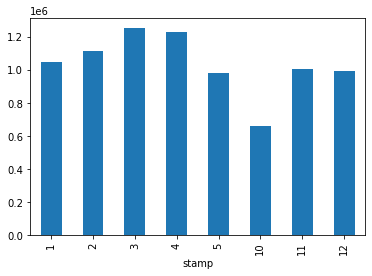

In [64]:
%matplotlib inline
data.groupby(data['stamp'].dt.month).size().plot(kind = 'bar')

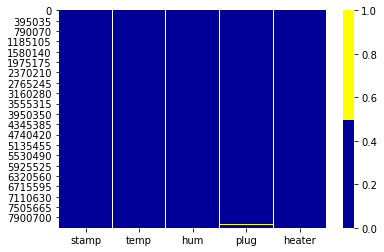

In [65]:
cols = data.columns[:30] # первые 30 колонок
# определяем цвета 
# желтый - пропущенные данные, синий - не пропущенные
colors = ['#000099', '#ffff00'] 
a = sns.heatmap(data[cols].isnull(), cmap=sns.color_palette(colors))

In [66]:
data["temp"].isnull().mean()

2.4108791403383595e-07

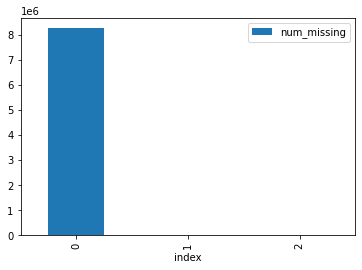

In [67]:
# сначала создаем индикатор для признаков с пропущенными данными
for col in data.columns:
    missing = data[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:  
#         print('created missing indicator for: {}'.format(col))
        data['{}_ismissing'.format(col)] = missing
        
# затем на основе индикатора строим гистограмму
ismissing_cols = [col for col in data.columns if 'ismissing' in col]
data['num_missing'] = data[ismissing_cols].sum(axis=1)
u = data['num_missing'].value_counts().reset_index().sort_values(by='index').plot.bar(x='index')

In [68]:
data.num_missing.mean()

0.004060523192114882

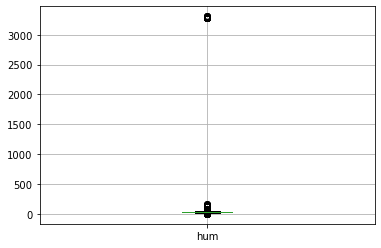

In [69]:
data.boxplot(column=['hum'])

In [70]:
misscount = data.isna().sum()
misscount[misscount>0]

temp          2
hum           2
plug      32653
heater     1028
dtype: int64

In [71]:
data[data.plug_ismissing == True]

,stamp,temp,hum,plug,heater,temp_ismissing,hum_ismissing,plug_ismissing,heater_ismissing,num_missing
325,2020-10-14 15:49:06.954412,26.000000,47.000000,NaN,1.0,False,False,True,False,1
326,2020-10-14 15:49:16.351531,26.000000,48.000000,NaN,1.0,False,False,True,False,1
327,2020-10-14 15:49:25.596830,26.000000,48.000000,NaN,1.0,False,False,True,False,1
328,2020-10-14 15:49:32.347595,26.000000,48.000000,NaN,1.0,False,False,True,False,1
348,2020-10-14 15:50:44.642289,26.000000,48.000000,NaN,1.0,False,False,True,False,1
...,...,...,...,...,...,...,...,...,...,...
8190128,2021-05-23 22:19:26.338102,25.299999,30.600000,NaN,0.0,False,False,True,False,1
8190129,2021-05-23 22:19:33.067454,25.299999,30.700001,NaN,0.0,False,False,True,False,1
8190130,2021-05-23 22:19:39.826101,25.299999,30.700001,NaN,0.0,False,False,True,False,1
8190131,2021-05-23 22:19:46.584291,25.299999,30.799999,NaN,0.0,False,False,True,False,1


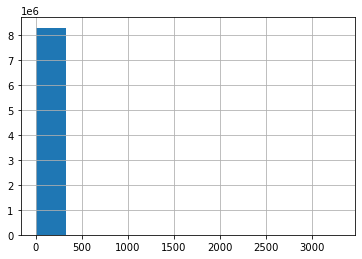

In [72]:
data.hum.hist()

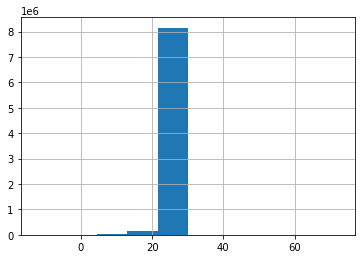

In [73]:
data.temp.hist()

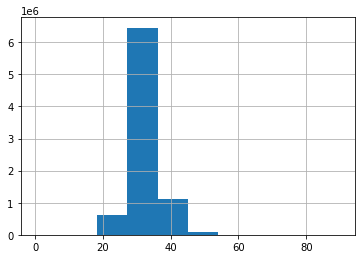

In [74]:
data['hum'].mask(data['hum'].between(-np.inf, 0), inplace=True)
data['hum'].mask(data['hum'].between(100, np.inf), inplace=True)

data.hum.hist()

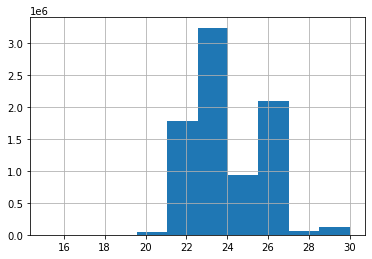

In [75]:
data['temp'].mask(data['temp'].between(-np.inf, 15), inplace=True)
data['temp'].mask(data['temp'].between(40, np.inf), inplace=True)

data.temp.hist()

In [76]:
data=data.dropna()
misscount = data.isna().sum()

misscount[misscount>0]

Series([], dtype: int64)

In [77]:
y_plug = data.plug
y_heater=data.heater
data.drop(columns=['plug', 'heater'], inplace=True)

In [78]:
data

,stamp,temp,hum,temp_ismissing,hum_ismissing,plug_ismissing,heater_ismissing,num_missing
0,2020-10-14 15:22:31.111918,25.0,51.000000,False,False,False,False,0
1,2020-10-14 15:22:32.914186,26.0,48.000000,False,False,False,False,0
2,2020-10-14 15:22:37.486081,26.0,49.000000,False,False,False,False,0
3,2020-10-14 15:22:39.234348,26.0,48.000000,False,False,False,False,0
4,2020-10-14 15:22:41.081851,26.0,49.000000,False,False,False,False,0
...,...,...,...,...,...,...,...,...
8295724,2021-05-26 11:54:12.172836,26.4,29.700001,False,False,False,False,0
8295725,2021-05-26 11:54:13.796678,26.4,29.700001,False,False,False,False,0
8295726,2021-05-26 11:54:15.421471,26.4,29.700001,False,False,False,False,0
8295727,2021-05-26 11:54:17.093325,26.4,29.700001,False,False,False,False,0


## add time

In [85]:
data['hour'] = data.stamp.dt.hour


data['hour_sin'] = np.sin(2 * np.pi * data.stamp.dt.hour/24)
data['hour_cos'] = np.cos(2 * np.pi * data.stamp.dt.hour/24)

In [88]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [97]:
data['month'] = data.stamp.dt.month
data = encode(data, 'month', 12)

data['day'] = data.stamp.dt.month
data = encode(data, 'day', 365)

data['seconds']=(data.stamp.dt.hour * 3600) + (data.stamp.dt.minute * 60) + data.stamp.dt.second + (data.stamp.dt.microsecond / 1000000.0)
data = encode(data, 'seconds', 86400)

data['weekday']=data.stamp.dt.dayofweek
data = encode(data, 'weekday', 7)


In [100]:
data.columns

Index(['stamp', 'temp', 'hum', 'temp_ismissing', 'hum_ismissing',
       'plug_ismissing', 'heater_ismissing', 'num_missing', 'hour_sin',
       'hour_cos', 'month', 'month_sin', 'month_cos', 'day', 'day_sin',
       'day_cos', 'seconds', 'seconds_sin', 'seconds_cos', 'weekday',
       'weekday_sin', 'weekday_cos'],
      dtype='object')

# logistic regression

In [101]:
from sklearn.model_selection import TimeSeriesSplit
X = data[['temp', 'hum','hour_sin',
       'hour_cos',  'month_sin', 'month_cos',  'day_sin',
       'day_cos',  'seconds_sin', 'seconds_cos', 'weekday_sin', 'weekday_cos']]
y = y_plug


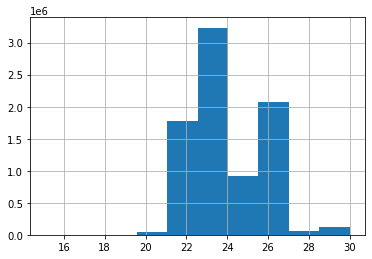

In [38]:
X.temp.hist()

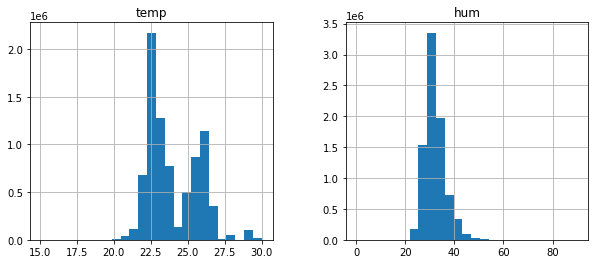

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
X_plot = X.loc[:, X.columns != 'stamp']


i = 0
for axis in axes:
    X_plot.hist(column = X_plot.columns[i], bins = 25, ax=axis)
    i = i+1

In [127]:
def sample_first_prows(data, perc=0.7):
    return data.head(int(len(data)*(perc)))

train = sample_first_prows(X)
test = X.iloc[max(train.index):]

y_train = sample_first_prows(y)
y_test = y.iloc[max(train.index):]

In [128]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss='log', learning_rate='constant', eta0=0.1, random_state=13, verbose=1)
clf.fit(train, y_train)
y_pred_sgdclf = clf.predict(train)
y_pred_sgdclftest = clf.predict(test)


-- Epoch 1
Norm: 98.70, NNZs: 12, Bias: 157.110298, T: 5771171, Avg. loss: 27.844715
Total training time: 1.48 seconds.
-- Epoch 2
Norm: 97.60, NNZs: 12, Bias: 166.680017, T: 11542342, Avg. loss: 27.883499
Total training time: 2.97 seconds.
-- Epoch 3
Norm: 96.06, NNZs: 12, Bias: 166.758657, T: 17313513, Avg. loss: 27.875710
Total training time: 4.46 seconds.
-- Epoch 4
Norm: 97.62, NNZs: 12, Bias: 165.649750, T: 23084684, Avg. loss: 27.882095
Total training time: 5.94 seconds.
-- Epoch 5
Norm: 99.02, NNZs: 12, Bias: 166.617219, T: 28855855, Avg. loss: 27.902297
Total training time: 7.43 seconds.
-- Epoch 6
Norm: 97.56, NNZs: 12, Bias: 165.135943, T: 34627026, Avg. loss: 27.910757
Total training time: 8.91 seconds.
Convergence after 6 epochs took 8.91 seconds


In [129]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_pred_sgdclf)

array([[2404261,  865726],
       [ 595156, 1906028]], dtype=int64)

In [132]:
y_pred_prob=[item[1] for item in clf.predict_proba(train)] 

In [134]:
from sklearn.metrics import precision_recall_curve
precision_array, recall_array, thresholds = precision_recall_curve(y_train, y_pred_prob)

In [135]:
from sklearn.metrics import auc
auc(recall_array, precision_array)

0.7781037044695789

## on test

In [136]:
confusion_matrix(y_test, y_pred_sgdclftest)

array([[1198005,  133705],
       [ 795075,  325887]], dtype=int64)

In [138]:
y_pred_prob=[item[1] for item in clf.predict_proba(test)] 
precision_array, recall_array, thresholds = precision_recall_curve(y_test, y_pred_prob)

In [139]:
auc(recall_array, precision_array)

0.6824316004761628

# Random Forests

In [140]:
tscv = TimeSeriesSplit(n_splits=10)
print(tscv)
for train_index, test_index in tscv.split(X):
     print("TRAIN:", train_index, "TEST:", test_index)

TimeSeriesSplit(max_train_size=None, n_splits=5)
TRAIN: [      0       1       2 ... 1374088 1374089 1374090] TEST: [1374091 1374092 1374093 ... 2748176 2748177 2748178]
TRAIN: [      0       1       2 ... 2748176 2748177 2748178] TEST: [2748179 2748180 2748181 ... 4122264 4122265 4122266]
TRAIN: [      0       1       2 ... 4122264 4122265 4122266] TEST: [4122267 4122268 4122269 ... 5496352 5496353 5496354]
TRAIN: [      0       1       2 ... 5496352 5496353 5496354] TEST: [5496355 5496356 5496357 ... 6870440 6870441 6870442]
TRAIN: [      0       1       2 ... 6870440 6870441 6870442] TEST: [6870443 6870444 6870445 ... 8244528 8244529 8244530]


In [148]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


In [147]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(train, y_train)

# here is x parameters are randomly selected
y_pred_rf = rnd_clf.predict(X_test)


NameError: name 'accuracy_score' is not defined

In [149]:
accuracy_score(y_test, y_pred_rf)

0.7867089443676122

In [153]:
y_pred_prob=[item[1] for item in rnd_clf.predict_proba(test)] 
precision_array, recall_array, thresholds = precision_recall_curve(y_test, y_pred_prob)
auc(recall_array, precision_array)

0.7278291206209462

In [152]:
rnd_clf.feature_importances_
for name, score in zip(X.columns, rnd_clf.feature_importances_):
    print(name, score)

temp 0.051225466464124035
hum 0.007485995363002761
hour_sin 0.13992024806072376
hour_cos 0.11315791202644278
month_sin 0.10579854366204978
month_cos 0.011796977133435554
day_sin 0.014920140291280873
day_cos 0.016753000998067823
seconds_sin 0.2226705293909177
seconds_cos 0.10853372485678695
weekday_sin 0.1770501813723793
weekday_cos 0.03068728038078878


In [173]:
rnd_clf.

2

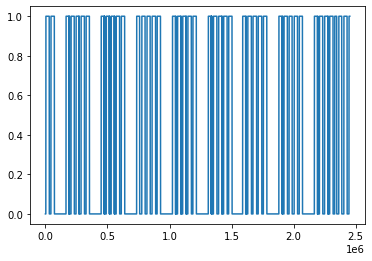

In [176]:
plt.plot(y_pred_rf)

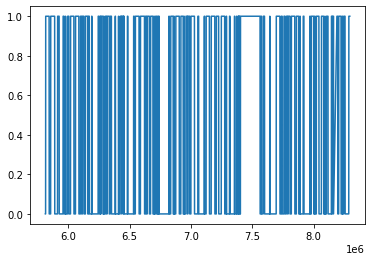

In [177]:
plt.plot(y_test)

In [145]:
tscv = TimeSeriesSplit(n_splits=10)
data_split = tscv.split(X)
    
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)

# hyper-parameter space
param_grid_RF = {
    'rf_model__n_estimators' : [10,20,50,100,200,500,1000],
    'rf_model__max_features' : [0.6,0.8,"auto","sqrt"],
}
# gridsearch for the best hyper-parameter within the pipeline.
gs_rf = GridSearchCV(rnd_clf, param_grid=param_grid_RF, cv=data_split, n_jobs=-1)
# fit dataset
gs_rf.fit(X, y)

ValueError: Invalid parameter rf_model for estimator RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1,
                       random_state=42). Check the list of available parameters with `estimator.get_params().keys()`.

# FB prophet

In [21]:
ds=X.stamp
df=y.to_frame().join(ds)
df.columns =['y', 'ds']

In [ ]:
m = Prophet()
m.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


KeyError: 'metric_file'

Exception ignored in: 'stanfit4anon_model_f5236004a3fd5b8429270d00efcc0cf9_9045703871880297330._set_stanargs_from_dict'
Traceback (most recent call last):
  File "C:\Users\ksetd\Anaconda3\lib\site-packages\pystan\model.py", line 550, in optimizing
    ret, sample = fit._call_sampler(stan_args)
KeyError: 'metric_file'


In [1]:
!conda remove pystan fbprophet
!conda install --channel conda-forge pystan fbprophet

^C
Solving environment: ...working... done

# All requested packages already installed.

